In [1]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from time import time
import seaborn as sns

SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes
HORIZONTAL, VERTICAL = 0, 1

In [6]:
from metro_utils import (graph, extract_stations, pairs2rails, simulated_annealing,
                         subsets, total_distance, gen_distance_matrix, graph_x, initialise)
from station import Station
from city import City
from collections import defaultdict as dd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from tqdm import tqdm
import networkx as nx
from networkx import from_numpy_matrix

if 1:
    # Load test cases
    # Highly recommend https://www.mathsisfun.com/data/cartesian-coordinates-interactive.html for creating these easily

    from json import load

    ignore_fields = ["description", "comment", "source"]
    def filter_ignore(d):
        return {k: v for k, v in d.items() if k not in ignore_fields}

    with open("test_cases.json", "r") as f:
        tests = load(f, object_hook=filter_ignore)

    # Choose problem to use in code below
    test_choice = "3_cluster"
    locations = tests[test_choice]["locations"]
    N_STATIONS = len(locations)
    kinds = tests[test_choice]["kinds"]

    city = City(**tests[test_choice])
    stations = city.stations

In [7]:
M = 1e10

def edge_sum(stations, x):
    connections = x.sum(axis=2)
    dist = gen_distance_matrix(city)
    # weighted_adjacency is edge weight where edge exists, else 0
    weighted_adjacency = connections * dist
    G = from_numpy_matrix(weighted_adjacency)
    return G.size('weight')

def total_distance_transfer_costs(path, dists):      
    dist = 0
    i = path[0]
    for j in path[1:]:
        dist += dists[i, j]
        i = j
            
    return dist

def cost_transfer(city, x):
    stations = city.stations
    N = x.shape[0]
    K = x.shape[2]

    dist = gen_distance_matrix(city)
    final_dists = np.zeros((N*K, N*K))
    
    total_line_lengths = 0
    
    for k in range(K):
        # Intra line (Real Distance Costs)
        line_length = (x[:, :, k]*dist).sum() / 2
        total_line_lengths += line_length
        final_dists[N*k:N*(k+1), N*k:N*(k+1)] = x[:, :, k] * dist * 2*line_length
    
    average_wait_time = 2*total_line_lengths/K
    
    for k1 in range(K):
        for k2 in range(k1, K):
            if k1 != k2:
                # Inter line (Artificial Transfer Costs)
                s1s = x[:, :, k1].sum(axis=0).astype(int)
                s2s = x[:, :, k2].sum(axis=0).astype(int)
                shared = (s1s != 0) & (s2s != 0)
                shared_is = np.argwhere(shared > 0).reshape(-1,)
                final_dists[N*k1+shared_is, N*k2+shared_is] = average_wait_time
                final_dists[N*k2+shared_is, N*k1+shared_is] = average_wait_time
    
    G = from_numpy_matrix(final_dists)
    
    all_paths = list(nx.all_pairs_shortest_path(G))
    
    station_dists = []
    all_kinds = {s.kind for s in stations}

    idx2station = lambda i: city.get_station(i % N)

    for i in range(N):
        start = stations[i]

        distances = {kind: M for kind in all_kinds if kind != start.kind}

        paths = [(end%N, path) for k in range(K) for (end, path) in all_paths[N*k + i][1].items()]

        # Get its kind
        for j, path in paths:
            end = stations[j]
            # For each other station: If kind is different
            if start.kind != end.kind:
                # Work out distance to that station and retain if min
                distances[end.kind] = min(distances[end.kind], 
                                          total_distance_transfer_costs(path, final_dists))

        station_dists.append(sum(distances.values()))
        
    # Sum of min distances + sum of graph edge weight
    return sum(station_dists) + edge_sum(stations, x) / M

In [9]:
best_x, best_cost = None, M
for restart in tqdm(range(10)):
    res_x, res_cost = simulated_annealing(city, K=3, cost_fn=cost_transfer, max_iter=10_000)
    if res_cost < best_cost:
        best_x, best_cost = res_x, res_cost
        print(best_cost)

 10%|████████▎                                                                          | 1/10 [00:23<03:31, 23.45s/it]

15.310832446309604


 20%|████████████████▌                                                                  | 2/10 [00:46<03:07, 23.50s/it]

14.290393614947613


 30%|████████████████████████▉                                                          | 3/10 [01:11<02:47, 23.97s/it]

13.414465667539625


 40%|█████████████████████████████████▏                                                 | 4/10 [01:36<02:26, 24.41s/it]

12.580292241531385


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:24<01:36, 24.04s/it]

11.392720884807495


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:11<00:47, 23.85s/it]

10.625696232941085


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:00<00:00, 24.04s/it]


10.625696232941085 2.0828935777509514


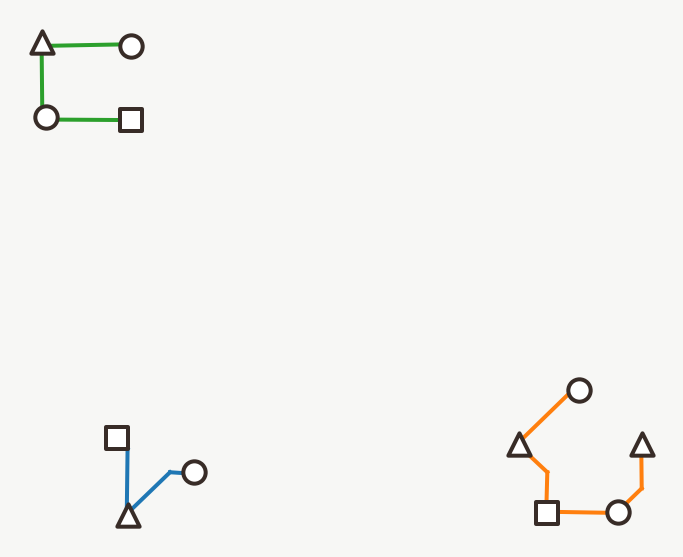

In [10]:
print(cost_transfer(city, best_x), edge_sum(city.stations, best_x))

graph_x(city.stations, best_x, jitter=1, equal_aspect=True, filename='sa_'+test_choice, show_station_ids=False)
graph_x(city.stations, best_x, jitter=1, equal_aspect=True, show_station_ids=False)

295.95687862643035 6.739970414071697


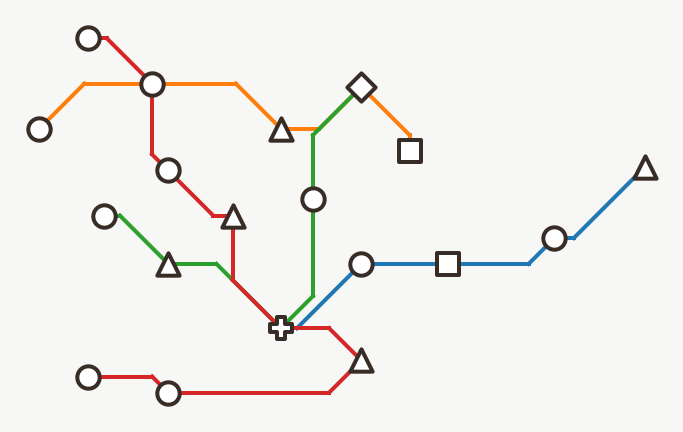

In [26]:
print(cost_transfer(city, best_x), edge_sum(city.stations, best_x))

#graph_x(city.stations, best_x, jitter=0, equal_aspect=True, filename='sa_barcelona', show_station_ids=False)
graph_x(city.stations, best_x, jitter=0, equal_aspect=True, show_station_ids=False)

In [6]:
# Get the connections
connxns_tsp = {0: [(1, 0), (0, 8), (8, 9), (9, 10), (10, 13), (13, 14), (14, 11), (11, 15), (15, 12), 
                   (12, 16), (16, 17), (17, 18), (18, 4), (4, 7), (7, 6), (6, 3), (3, 2), (2, 5), (5, 1)]
}

connxns_ant = {0: [(8, 0), (0, 1), (1, 5), (5, 9), (9, 10), (10, 2), (2, 3), (3, 6), (6, 7), (7, 4)] ,
               1: [(11, 15), (15, 12), (12, 16)],
               2: [(13, 14)],
               3: [(17, 18)]
}

connxns_sdvrp = {0: [(8, 0), (0, 1), (1, 5), (5, 9), (9, 10), (10, 2), (2, 3)], 
                 1: [(18, 17), (17, 16), (16, 12), (12, 3), (3, 6)], 
                 2: [(4, 7), (7, 6), (6, 3)], 
                 3: [(13, 14), (14, 11), (11, 15), (15, 12)]
}

connxns_human = {0: [(0,1),(1,2),(2,3),(3,4),(4,16)],
                 1: [(8,9),(9,10),(10,11),(11,12),(12,16)],
                 2: [(13,14),(14,15),(15,16),(16,17),(17,18)],
                 3: [(5,6),(6,7),(7,16),(16,12)]}

def get_x(connxns):
    adj_matrices = []
    for c in connxns:
        adj_matrices.append([[1 if (i,j) in connxns[c] or (j,i) in connxns[c] else 0 for i in range(19)] for j in range(19)])
    return np.array(adj_matrices).transpose(2,1,0)

x0 = get_x(connxns_tsp)
x1 = get_x(connxns_ant)
x2 = get_x(connxns_sdvrp)
x4 = get_x(connxns_human)

1163.0544843239018 6.365411972844541


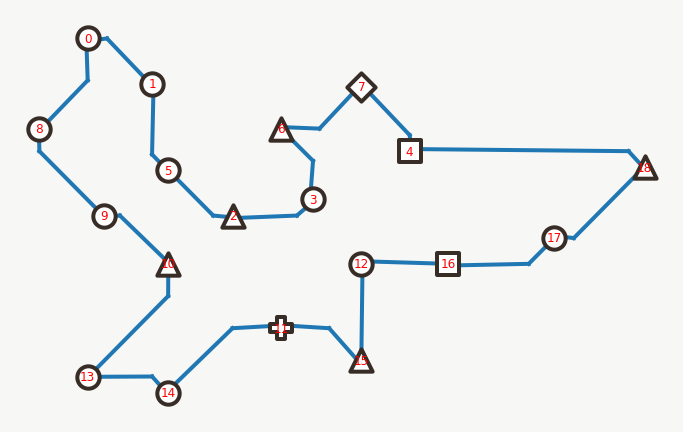

In [7]:
tensor = x0
print(cost_transfer(city, tensor), edge_sum(city.stations, tensor))
#graph_x(city.stations, tensor, jitter=2, equal_aspect=True, show_station_ids=False, filename='human_barcelona')
graph_x(city.stations, tensor, jitter=2, equal_aspect=True, show_station_ids=1)

In [231]:
if 1:
    # Load test cases
    # Highly recommend https://www.mathsisfun.com/data/cartesian-coordinates-interactive.html for creating these easily

    from json import load

    ignore_fields = ["description", "comment", "source"]
    def filter_ignore(d):
        return {k: v for k, v in d.items() if k not in ignore_fields}

    with open("test_cases.json", "r") as f:
        tests = load(f, object_hook=filter_ignore)

    # Choose problem to use in code below
    test_choice = "4_cluster"
    locations = tests[test_choice]["locations"]
    N_STATIONS = len(locations)
    kinds = tests[test_choice]["kinds"]

    city = City(**tests[test_choice])
    stations = city.stations

In [19]:
best_x, best_cost, final_cur_xs, final_new_xs = None, M, None, None
for restart in tqdm(range(10)):
    res_x, res_cost, cur_xs, new_xs = simulated_annealing(city, K=4, cost_fn=cost_transfer, max_iter=25_000, 
                                                          cutoff_val=0.001, save=True)
    if res_cost < best_cost:
        best_x, best_cost, final_cur_xs, final_new_xs = res_x, res_cost, cur_xs, new_xs
        print(best_cost)

 10%|████████▏                                                                         | 1/10 [02:02<18:26, 122.98s/it]

96.50404697284642


 20%|████████████████▍                                                                 | 2/10 [04:04<16:16, 122.02s/it]

88.48858206207626


 30%|████████████████████████▌                                                         | 3/10 [06:06<14:15, 122.20s/it]

83.26571153550438


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [20:50<00:00, 125.07s/it]


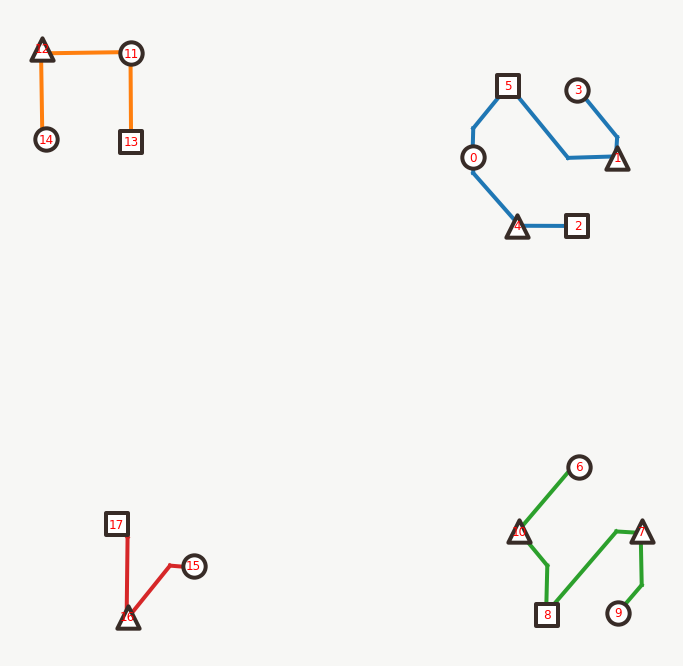

In [20]:
graph_x(city.stations, best_x, jitter=1)

In [78]:
import pandas as pd

if 0:
    costs = [cost_transfer(city, x) for x in xs] + [best_cost]

    pd.DataFrame(costs).to_csv('costs.csv')

In [104]:
all_costs = [cost_transfer(city, x) for x in final_new_xs]

In [19]:
import pandas as pd

costs = pd.read_csv('costs.csv')['0'].cummin()

costs

0      713.681436
1      713.681436
2      713.681436
3      683.753911
4      632.101562
          ...    
411     83.714384
412     83.714384
413     83.714384
414     83.714384
415     83.265712
Name: 0, Length: 416, dtype: float64

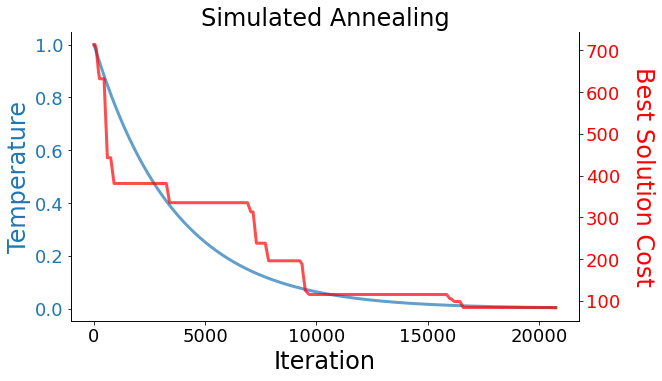

In [27]:
if 0:
    from scipy.signal import savgol_filter
    yy = savgol_filter(costs, 3, 1)

    xx = np.arange(len(costs)) * 50

    def T(t):
        return np.exp(np.log(0.001)*t / 25_000)

    fig, ax2 = plt.subplots(figsize=(10, 6))
    ax1 = ax2.twinx()
    ax2.set_title('Simulated Annealing')
    ax2.set_xlabel('Iteration')
    c1, c2 = 'red', 'C0'

    ax1.plot(xx, yy, c=c1, lw=LW, alpha=0.7)
    #ax1.yaxis.offsetText.set_fontsize(SMALL)
    ax1.spines['top'].set_color('none')
    ax1.tick_params(axis='y', labelcolor=c1)
    ax1.tick_params(axis='both', which='major')
    ax1.set_ylabel('Best Solution Cost', c=c1, rotation=270)
    ax1.yaxis.set_label_coords(1.15, 0.5)
    #ax1.set_ylim(20, 800)
    #ax1.set_yscale('log')

    ax2.plot(xx, T(xx), c=c2, lw=LW, alpha=0.7)
    #ax2.yaxis.offsetText.set_fontsize(SMALL)
    ax2.spines['top'].set_color('none')
    ax2.tick_params(axis='y', labelcolor=c2)
    ax2.tick_params(axis='both', which='major')
    ax2.set_ylabel('Temperature', c=c2)

    plt.tight_layout()
    plt.savefig('simulated_annealing2.png', facecolor='white', transparent=False)
    plt.show()

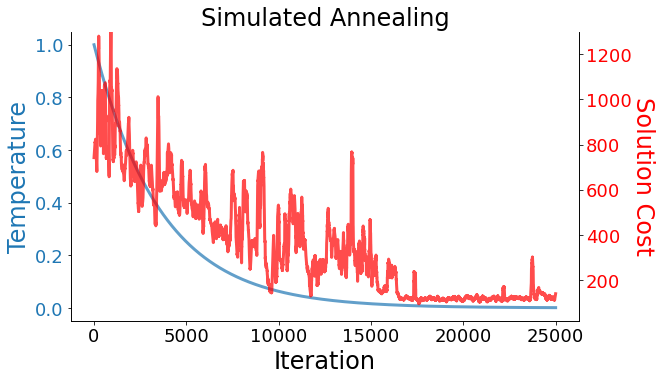

In [134]:
if 0:
    from scipy.signal import savgol_filter
    yy = savgol_filter(all_costs, 101, 1)

    xx = np.arange(len(all_costs))

    def T(t):
        return np.exp(np.log(0.001)*t / 25_000)

    fig, ax2 = plt.subplots(figsize=(10, 6))
    ax1 = ax2.twinx()
    ax2.set_title('Simulated Annealing')
    ax2.set_xlabel('Iteration')
    c1, c2 = 'red', 'C0'

    ax1.plot(xx, yy, c=c1, lw=LW, alpha=0.7)
    #ax1.yaxis.offsetText.set_fontsize(SMALL)
    ax1.spines['top'].set_color('none')
    ax1.tick_params(axis='y', labelcolor=c1)
    ax1.tick_params(axis='both', which='major')
    ax1.set_ylabel('Solution Cost', c=c1, rotation=270)
    ax1.yaxis.set_label_coords(1.15, 0.5)
    ax1.set_ylim(20, 1_300)
    #ax1.set_yscale('log')

    ax2.plot(xx, T(xx), c=c2, lw=LW, alpha=0.7)
    #ax2.yaxis.offsetText.set_fontsize(SMALL)
    ax2.spines['top'].set_color('none')
    ax2.tick_params(axis='y', labelcolor=c2)
    ax2.tick_params(axis='both', which='major')
    ax2.set_ylabel('Temperature', c=c2)

    plt.tight_layout()
    plt.savefig('simulated_annealing.png', facecolor='white', transparent=False)
    plt.show()

# Create GIF

In [31]:
if 0:
    filenames = []

    xs = final_new_xs[:20727+1:50]
    for i, x in tqdm(enumerate(xs), total=len(xs)):
        filename = f'4_cluster{i:0>7}'
        filenames.append(filename)
        graph_x(city.stations, x, jitter=1, filename=filename, show_station_ids=False)


    filename = f'4_cluster{i+1:0>7}'
    filenames.append(filename)
    graph_x(city.stations, best_x, jitter=1, filename=filename, show_station_ids=False)

100%|████████████████████████████████████████████████████████████████████████████████| 415/415 [02:25<00:00,  2.85it/s]


In [ ]:
%%time
if 0:
    import imageio

    with imageio.get_writer('4_cluster.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(f'images/{filename}.png')
            writer.append_data(image)
        for _ in range(40):
            image = imageio.imread(f'images/{filename}.png')
            writer.append_data(image)

In [101]:
if 0:
    import matplotlib.image as mpimg

    cM, cm = 1_000, min(costs)
    m, M = 140, 730

    def f(y):
        if y > cM:
            y = cM

        p = (y - cm) / (cM - cm)

        return M - p * (M - m)
    
    def T(t):
        return np.exp(np.log(0.001)*50*t / 20727)

    for i, (filename, cost) in tqdm(list(enumerate(zip(filenames, costs)))):
        fig, ax = plt.subplots(figsize=(24, 24))

        ax.axis('off')

        ax.plot([780, 820], 2*[f(cost)], c='red', lw=5, label='Solution Cost', zorder=20)
        ax.plot([780, 820], 2*[f(T(i) * (cM - cm) + cm)], c='C0', lw=5, zorder=10, label='Temperature')
        ax.plot([780, 820], 2*[f(cm)], c='black', lw=5)
        ax.plot([780, 820], 2*[f(cM)], c='black', lw=5)

        img = mpimg.imread(f'images/{filename}.png')
        imgplot = plt.imshow(img)

        ax.legend(loc='upper center', ncol=2, frameon=False, fontsize=40, bbox_to_anchor=[0.53, 0.92])
        
        plt.savefig('final/' + filename + '.png', facecolor='white', transparent=False, dpi=fig.dpi)
        plt.close()

        #plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 416/416 [04:12<00:00,  1.65it/s]


In [103]:
%%time
if 0:
    import imageio

    with imageio.get_writer('4_cluster_final.gif', mode='I') as writer:
        for filename in tqdm(filenames):
            image = imageio.imread(f'final/{filename}.png')
            writer.append_data(image)
        for _ in range(40):
            image = imageio.imread(f'final/{filename}.png')
            writer.append_data(image)

CPU times: total: 2min 22s
Wall time: 2min 26s


# Computational Study

In [20]:
from time import time
from itertools import product

n_trials = 3
max_iters = [100, 250, 500, 1_000, 2_500, 5_000, 10_000]
cutoff_vals = [0.0001, 0.001, 0.01, 0.1]
n_stations_range = range(4, 21, 2)

# Store results
res_n_stations = []
res_max_iter__ = []
res_cutoff_val = []
res_opt_cost__ = []

res_time_taken = []
res_soltn_cost = []

hyper_params = list(product(range(n_trials), n_stations_range))

for trial, n_stations in tqdm(hyper_params):
    city, opt_x = gen_test_city(n_stations)
    opt_cost = cost_transfer(city, opt_x)
    for max_iter in max_iters:
        for cutoff_val in cutoff_vals:
            t0 = time()
            _, soltn_cost = simulated_annealing(city, K=2, cost_fn=cost_transfer, 
                                                max_iter=max_iter, cutoff_val=cutoff_val)
            t1 = time()
            
            res_n_stations.append(n_stations)
            res_max_iter__.append(max_iter  )
            res_cutoff_val.append(cutoff_val)
            res_time_taken.append(t1 - t0   )
            res_soltn_cost.append(soltn_cost)
            res_opt_cost__.append(opt_cost  )

100%|███████████████████████████████████████████████████████████████████████████████| 27/27 [2:28:19<00:00, 329.62s/it]


In [24]:
if 0:
    import pandas as pd

    results = pd.DataFrame({'n_stations': res_n_stations, 'max_iter': res_max_iter__, 
                            'cutoff_val': res_cutoff_val, 'time': res_time_taken, 'cost': res_soltn_cost})

    results.to_csv('results3.csv', index=False)

# Results

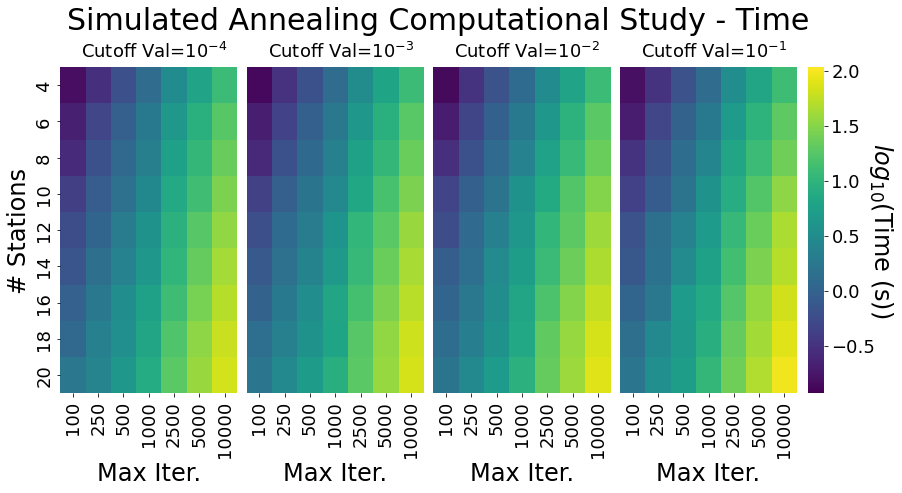

In [103]:
import pandas as pd

results = pd.read_csv('results3.csv')

df = results.copy()

fig, axes = plt.subplots(ncols=df.cutoff_val.nunique(), figsize=(14, 6),
             gridspec_kw={'width_ratios': [1, 1, 1, 1.25]})

y = 'time'

df[y] = np.log10(df[y])

vmin, vmax = df[y].min(), df[y].max()

plt.suptitle('Simulated Annealing Computational Study - Time', fontsize=LARGE, x=0.5, y=1.02)

for ax, cutoff_val in zip(axes, df.cutoff_val.unique()):
    ax.set_title(f'Cutoff Val=$10^{{{int(np.log10(cutoff_val))}}}$', x=0.532, y=1.01, fontsize=SMALL)

gb = df.groupby(['cutoff_val', 'n_stations', 'max_iter']).mean().reset_index()

for i, cutoff_val in enumerate(results.cutoff_val.unique()):
    cbar = (i == results.cutoff_val.nunique() - 1)
    sns.heatmap(gb[gb.cutoff_val == cutoff_val].pivot(index='n_stations', 
                                                      columns='max_iter', values=y),
                ax=axes[i], cmap='viridis', vmin=vmin, vmax=vmax, cbar=cbar)
    
    
    axes[i].set_xlabel('Max Iter.', fontsize=MED)


cbar = axes[-1].collections[0].colorbar
cbar.set_label('$log_{10}$(Time (s))', fontsize=MED, rotation=270, labelpad=20)

for ax in axes[1:]:
    ax.tick_params(left=False)
    ax.set_yticklabels([])
    ax.set_ylabel('')
axes[0].set_ylabel('# Stations')

plt.subplots_adjust(wspace=0.05, hspace=0)
#plt.savefig('annealing_time2.png', dpi=fig.dpi*2, bbox_inches="tight", 
#            facecolor='white', transparent=False)
plt.show()

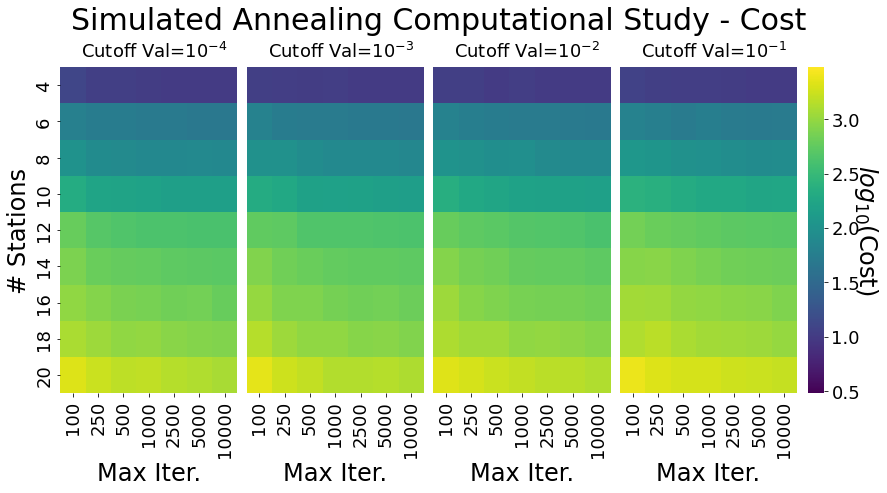

In [104]:
df = results.copy()

fig, axes = plt.subplots(ncols=df.cutoff_val.nunique(), figsize=(14, 6),
             gridspec_kw={'width_ratios': [1, 1, 1, 1.25]})

y = 'cost'

df[y] = np.log10(df[y])

vmin, vmax = df[y].min(), df[y].max()

plt.suptitle('Simulated Annealing Computational Study - Cost', fontsize=LARGE, x=0.5, y=1.02)

for ax, cutoff_val in zip(axes, df.cutoff_val.unique()):
    ax.set_title(f'Cutoff Val=$10^{{{int(np.log10(cutoff_val))}}}$', x=0.532, y=1.01, fontsize=SMALL)

gb = df.groupby(['cutoff_val', 'n_stations', 'max_iter']).mean().reset_index()

for i, cutoff_val in enumerate(results.cutoff_val.unique()):
    cbar = (i == results.cutoff_val.nunique() - 1)
    sns.heatmap(gb[gb.cutoff_val == cutoff_val].pivot(index='n_stations', columns='max_iter', values=y),
                ax=axes[i], cmap='viridis', vmin=vmin, vmax=vmax, cbar=cbar)
    
    
    axes[i].set_xlabel('Max Iter.', fontsize=MED)


cbar = axes[-1].collections[0].colorbar
cbar.set_label('$log_{10}$(Cost)', fontsize=MED, rotation=270, labelpad=20)

for ax in axes[1:]:
    ax.tick_params(left=False)
    ax.set_yticklabels([])
    ax.set_ylabel('')
axes[0].set_ylabel('# Stations')

plt.subplots_adjust(wspace=0.05, hspace=0)
#plt.savefig('annealing_cost2.png', dpi=fig.dpi*2, bbox_inches="tight", 
#            facecolor='white', transparent=False)
plt.show()

# Repeat Study With Fixed Cutoff

In [15]:
from time import time
from itertools import product
import pandas as pd

def gen_test_city(n_stations, gap=0.2):
    # Initialise square and circle
    xs = [0, 0.05]
    locations = [(xs[0], 0), (xs[1], 0)]
    kinds = ['square', 'triangle']
    
    for i in range(2, n_stations):
        base = xs[i % 2]
        dist = gap * (i//2)
        direction = 2 * (i % 2) - 1
        locations.append((base + dist*direction, 0))
        kinds.append('circle')
        
    opt_x = np.zeros((n_stations, n_stations, 2))
    
    # Line 1
    stations = [0] + [i for i in range(1, n_stations, 2)]
    
    start = stations[0]
    for end in stations[1:]:
        opt_x[start, end, 0] = opt_x[end, start, 0] = 1
        start = end
    
    # Line 2
    stations = [1] + [i for i in range(0, n_stations, 2)]
    
    start = stations[0]
    for end in stations[1:]:
        opt_x[start, end, 1] = opt_x[end, start, 1] = 1
        start = end
    
    city = City(locations=locations, kinds=kinds)
    
    return city, opt_x

if 0:

    n_trials = 3
    max_iters = np.ceil(np.logspace(np.log10(100), np.log10(50_000), 7)).astype(int)
    cutoff_vals = [0.0001]
    n_stations_range = [2, 3, 5, 7, 10, 15, 20, 25]

    # Store results
    res_n_stations = []
    res_max_iter__ = []
    res_cutoff_val = []
    res_opt_x_cost = []
    res_trials = []

    res_time_taken = []
    res_soltn_cost = []

    hyper_params = list(product(range(n_trials), n_stations_range))
    
    for trial, n_stations in tqdm(hyper_params):
        city, opt_x = gen_test_city(n_stations)
        opt_cost = cost_transfer(city, opt_x)
        for max_iter in max_iters:
            for cutoff_val in cutoff_vals:
                t0 = time()
                _, soltn_cost = simulated_annealing(city, K=2, cost_fn=cost_transfer, max_iter=max_iter, cutoff_val=cutoff_val)
                t1 = time()
    
                res_n_stations.append(n_stations)
                res_max_iter__.append(max_iter  )
                res_cutoff_val.append(cutoff_val)
                res_time_taken.append(t1 - t0   )
                res_soltn_cost.append(soltn_cost)
                res_opt_x_cost.append(opt_cost  )
                res_trials.append(trial)
    
    results = pd.DataFrame({'n_stations': res_n_stations, 'max_iter': res_max_iter__, 
                            'cutoff_val': res_cutoff_val, 'time': res_time_taken, 
                            'cost': res_soltn_cost, 'opt_cost': res_opt_x_cost,
                            'trial': res_trials})

    results.to_csv('results5.csv', index=False)
    
results = pd.read_csv('results5.csv')

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [48:12<00:00, 120.54s/it]


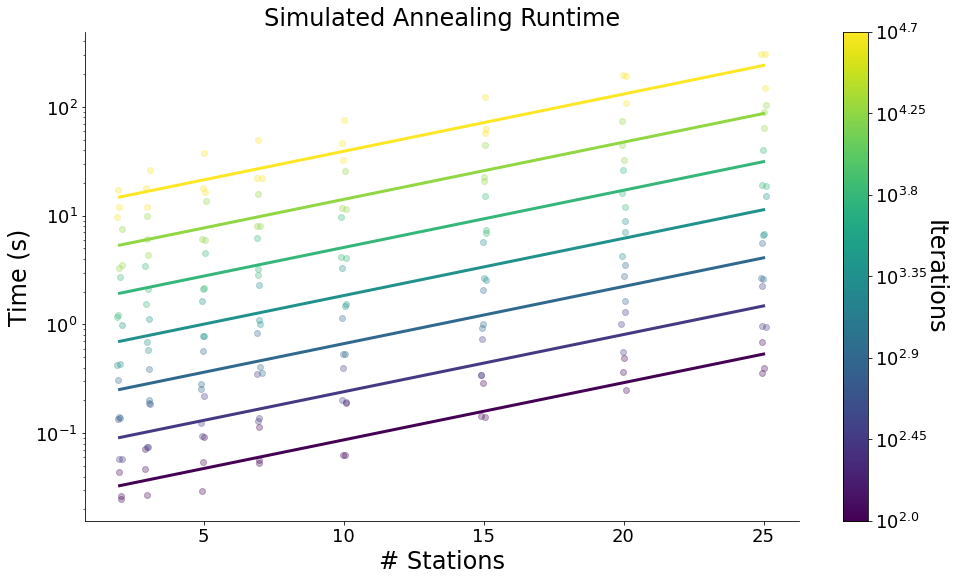

In [79]:
df = results.copy()

df['ones'] = 1

X = df[['ones', 'n_stations', 'max_iter']].copy()
X['max_iter'] = np.log10(X.max_iter)
X = X.to_numpy()

y = np.log10(df.time)

B = np.linalg.inv(X.T @ X) @ X.T @ y


y = 'time'
right = 1.1
x = 'n_stations'
z = 'max_iter'

# Colour according to heatmap colours, Set up confidence bound instead of dots

gb = df.groupby([x, z])
mean   = gb.mean().reset_index()
stds   = gb.std().reset_index()
counts = gb.count().reset_index()

fig, ax = plt.subplots(figsize=(16, 9))

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(np.log10(df[z].min()), np.log10(df[z].max()))

for i, z_val in enumerate(df[z].unique()):
    d = df[df[z] == z_val]
    m = mean[mean[z] == z_val]
    im = ax.scatter(d[x] + np.random.uniform(-0.1, 0.1, len(d[x])), d[y], 
               color=cmap(norm(np.log10(z_val))), alpha=0.3)
    #ax.plot(m[x], m[y])
    
for max_iter in df.max_iter.unique():
    xx = np.array([[df.n_stations.min(), np.log10(max_iter)],
                   [df.n_stations.max(), np.log10(max_iter)]])
    yy = np.power(10, np.concatenate([np.ones((2, 1)), xx], axis=1) @ B)
    
    ax.plot(xx[:, 0], yy, lw=LW, color=cmap(norm(np.log10(max_iter))))
    
cbar = fig.colorbar(im, ax=ax, ticks=np.linspace(0, 1, df.max_iter.nunique()))
cbar.set_ticklabels([f'$10^{{{power}}}$' for power in np.log10(df.max_iter.unique()).round(2)]) 
cbar.set_alpha(1)
cbar.draw_all()
cbar.ax.set_ylabel('Iterations', rotation=270, labelpad=20)
    
ax.set_title('Simulated Annealing Runtime')
ax.set_xlabel('# Stations')
ax.set_ylabel('Time (s)')

plt.yscale('log')
sns.despine()

#plt.savefig('runtime_stations.png', dpi=fig.dpi*2, bbox_inches="tight", 
#            facecolor='white', transparent=False)

plt.show()

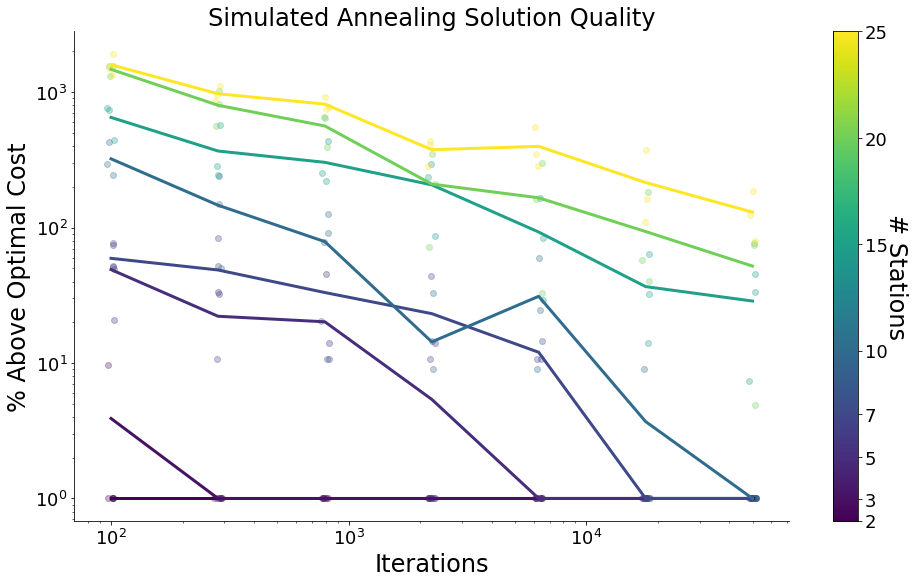

In [116]:
right = 1.1
z = 'n_stations'
x = 'max_iter'

# Get analytically optimal solution and check out how bad the algorithm is compared to true optimal

gb = df.groupby([x, z])
stds   = gb.std().reset_index()
counts = gb.count().reset_index()

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(df[z].min(), df[z].max())

fig, ax = plt.subplots(figsize=(16, 9))

for i, z_val in enumerate(df[z].unique()):
    d = df[df[z] == z_val].reset_index(drop=1)
    
    # Calculate for each trial the % of best loss
    d['pct'] = (100 * d.cost / d.opt_cost) - 100 + 1
    
    m = d.groupby(x)[['pct']].mean().reset_index()
    pct_diff = 0.04
    ax.scatter(d[x] + np.random.uniform(-pct_diff*d[x], pct_diff*d[x]), d['pct'], 
               color=cmap(norm(z_val)), alpha=0.3)
    ax.plot(m[x], m['pct'], lw=LW, color=cmap(norm(z_val)))
    
ax.set_title('Simulated Annealing Solution Quality')
ax.set_xlabel('Iterations')
ax.set_ylabel('% Above Optimal Cost')

plt.xscale('log')
plt.yscale('log')

cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks((df[z].unique() - df[z].min()) / (df[z].max() - df[z].min()))
cbar.set_ticklabels(df[z].unique()) 
cbar.set_alpha(1)
cbar.draw_all()
cbar.ax.set_ylabel('# Stations', rotation=270, labelpad=20)

sns.despine()

#plt.savefig('pct_cost.png', dpi=fig.dpi*2, bbox_inches="tight", 
#            facecolor='white', transparent=False)

plt.show()